This notebook is used to postprocessing the inverse modeling results of the cloud chamber model.

In [12]:
# Libraries
from pathlib import Path
import pandas as pd
import numpy as np

from kim.map import KIM
from kim.data import Data
from kim.mapping_model import MLP
from kim.utils import plot_sensitivity_mask, plot_sensitivity

import jax

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# # define the colors
# cmap = mpl.colors.ListedColormap(['white', 'k'])

# # create a normalize object the describes the limits of
# # each color
# bounds = [-.5, 0.5, 1.5]
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


In [3]:
jax.devices()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[CpuDevice(id=0)]

# Read the data

In [4]:
# File and folder paths
f_para = Path("./data/Output_512.csv")
f_state = Path("./data/Input_512.csv")


In [5]:
df_para, df_state = pd.read_csv(f_para),pd.read_csv(f_state)

In [6]:
y_vars, x_vars = df_para.keys().to_list(), df_state.keys().to_list()
y, x = df_para.values, df_state.values

In [7]:
x.shape, y.shape

((513, 1458), (513, 2))

# Load the preliminary analysis results

In [8]:
f_data_save = Path("./results/data")
data = Data(x, y)
data.load(f_data_save)


# Plot the sensitivity analysis results

In [9]:
def plot_sensitivity(sensitivity_mask, ax=None, xlabels=None, ylabels=None):

    if xlabels is not None and ylabels is not None:
       sensitivity_mask = pd.DataFrame(sensitivity_mask, index=xlabels, columns=ylabels)

    ax = sns.heatmap( sensitivity_mask, ax=ax, cmap='Blues')
    ax.set(title='Sensitivity heatmap')

def plot_sensitivity_mask(sensitivity_mask, ax=None, xlabels=None, ylabels=None):
    # define the colors
    cmap = mpl.colors.ListedColormap(['lightgrey', 'tab:blue'])

    # create a normalize object the describes the limits of
    # each color
    bounds = [-.5, 0.5, 1.5]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    if xlabels is not None and ylabels is not None:
       sensitivity_mask = pd.DataFrame(sensitivity_mask, index=xlabels, columns=ylabels)

    ax = sns.heatmap(
        sensitivity_mask, ax=ax, cmap=cmap, norm=norm, 
        cbar_kws={"ticks": [0, 1]}
      )
    ax.collections[0].colorbar.set_ticklabels(["sensitive", "not sensitive"], rotation=90)
    ax.set(title='Sensitivity mask')


[Text(0.5, 1.0, 'Sensitivity')]

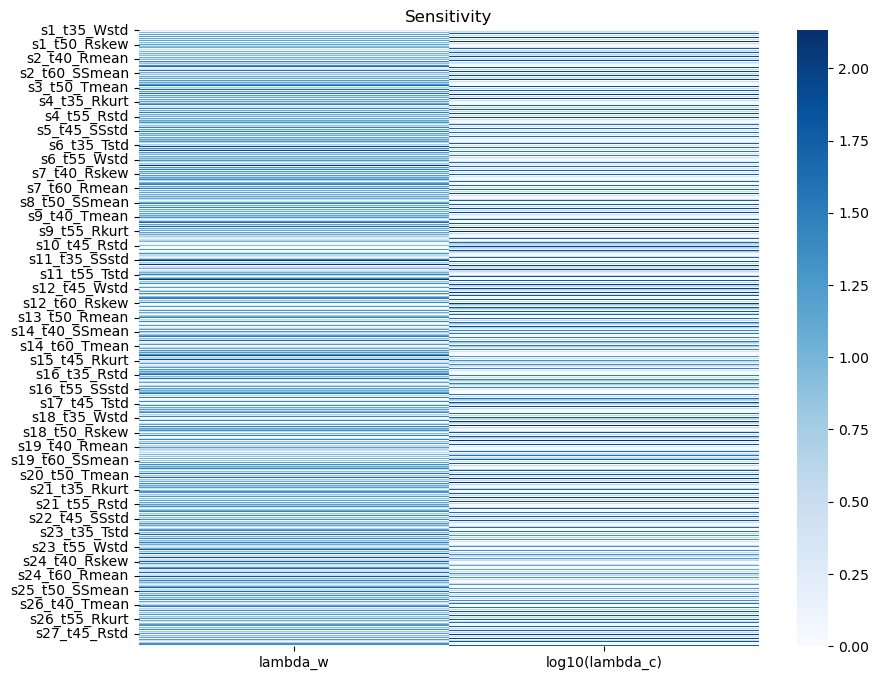

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_sensitivity(data.sensitivity, xlabels=x_vars, ylabels=y_vars)
ax.set(title='Sensitivity')


[Text(0.5, 1.0, 'Sensitivity mask')]

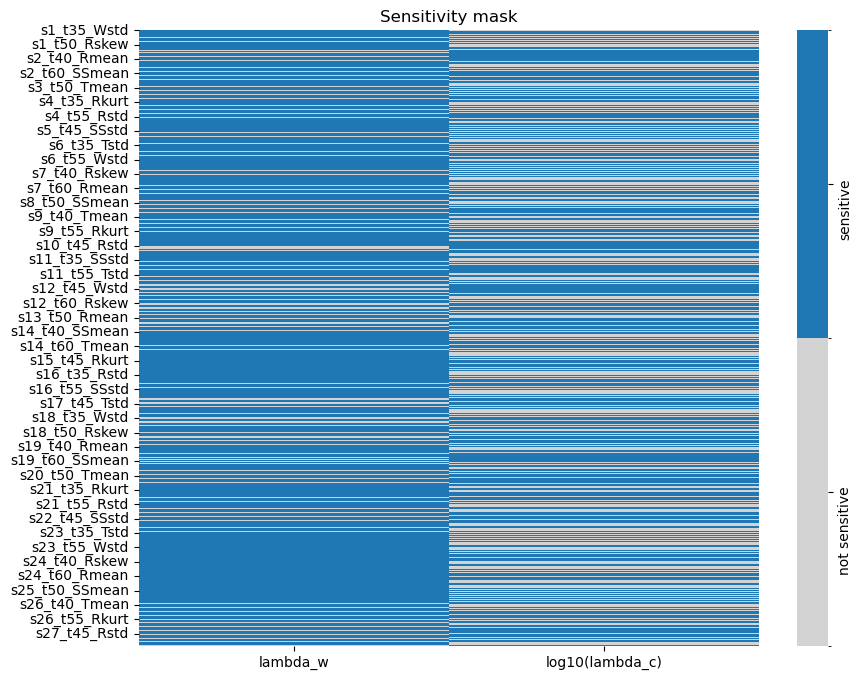

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_sensitivity_mask(data.sensitivity_mask, xlabels=x_vars, ylabels=y_vars)
ax.set(title='Sensitivity mask')


In [53]:
data.cond_sensitivity_mask.sum(axis=0)

array([949, 505])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_sensitivity_mask(data.cond_sensitivity_mask, xlabels=x_vars, ylabels=y_vars)
ax.set(title='Sensitivity + Redundancy filtering mask')


[Text(0.5, 1.0, 'Sensitivity + Redundancy filtering mask')]

## Plots specific to cloud chamber system

In [47]:
# Let's make a big pandas dataframe
loc = [int(xv.split('_')[0][1:]) for xv in x_vars]
time = [int(xv.split('_')[1][1:]) for xv in x_vars]
varn = [xv.split('_')[2] for xv in x_vars]
df_sen = pd.DataFrame()
df_sen['loc']  = loc
df_sen['time'] = time
df_sen['varn'] = varn
for i,yvarn in enumerate(y_vars):
    df_sen[yvarn] = data.sensitivity[:,i]
    df_sen[yvarn+"_mask"] = data.sensitivity_mask[:,i]
    df_sen[yvarn+"_condmask"] = data.cond_sensitivity_mask[:,i]    

varn_set = sorted(list(set(varn)))
time_set = sorted(list(set(time)))
loc_set = sorted(list(set(loc)))

# Set up the gradual changing color lines
# cmap = plt.cm.gist_rainbow  # You can choose other colormaps like 'plasma', 'inferno', 'magma', etc.
# colors = cmap(np.linspace(0, 1, len(loc_set)))

cmap1 = plt.cm.Blues_r
colors1 = cmap1(np.linspace(0.2, 0.8, 9))
cmap2 = plt.cm.Oranges_r
colors2 = cmap2(np.linspace(0.2, 0.8, 9))
cmap3 = plt.cm.Greys_r
colors3 = cmap3(np.linspace(0.2, 0.8, 9))
colors = np.concat([colors1, colors2, colors3])


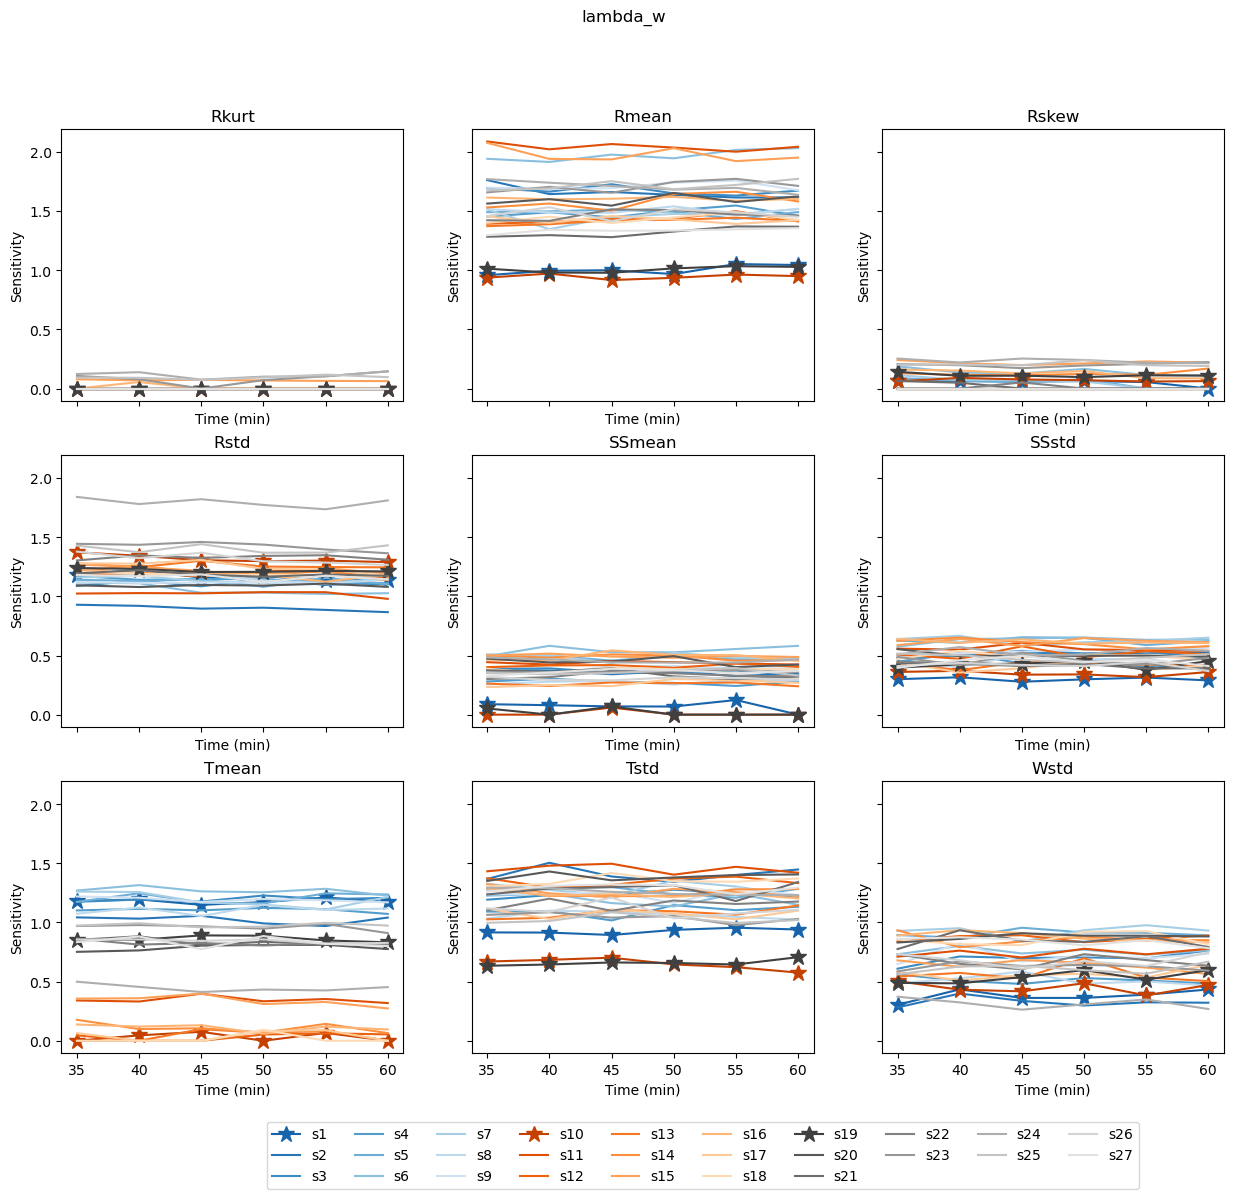

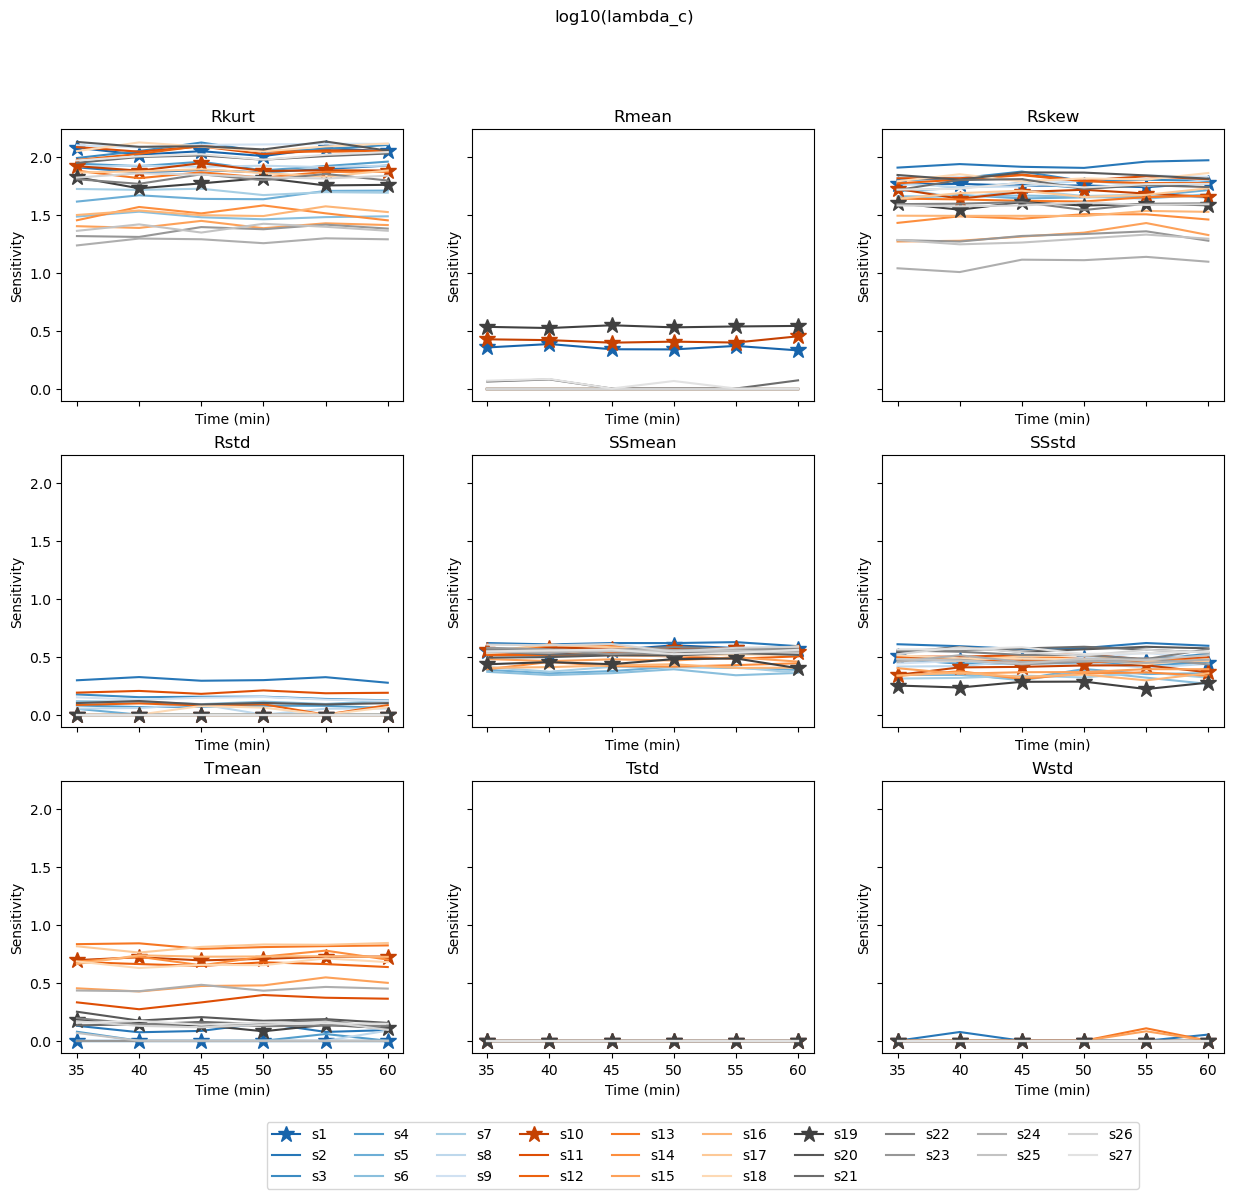

In [54]:
# Plot -- sensitivity only
for k,yvarn in enumerate(y_vars):
    fig, axes = plt.subplots(3, 3, figsize=(15,12), sharex=True, sharey=True)
    axes = axes.flatten()
    for i,varn in enumerate(varn_set):
        ax = axes[i]
        for j,loc in enumerate(loc_set):
            df = df_sen[(df_sen['varn']==varn) & (df_sen['loc']==loc)]
            t, d = df['time'].values, df[yvarn].values
            if loc in [1, 10, 19]:
                ax.plot(t, d, '-*', label=f"s{loc}", markersize=12, color=colors[j])
            else:
                ax.plot(t, d, label=f"s{loc}", color=colors[j])
        ax.set(title=varn, xlabel='Time (min)', ylabel='Sensitivity')
    ax.legend(loc=[-1.8, -0.5], ncols=10)
    plt.suptitle(yvarn)


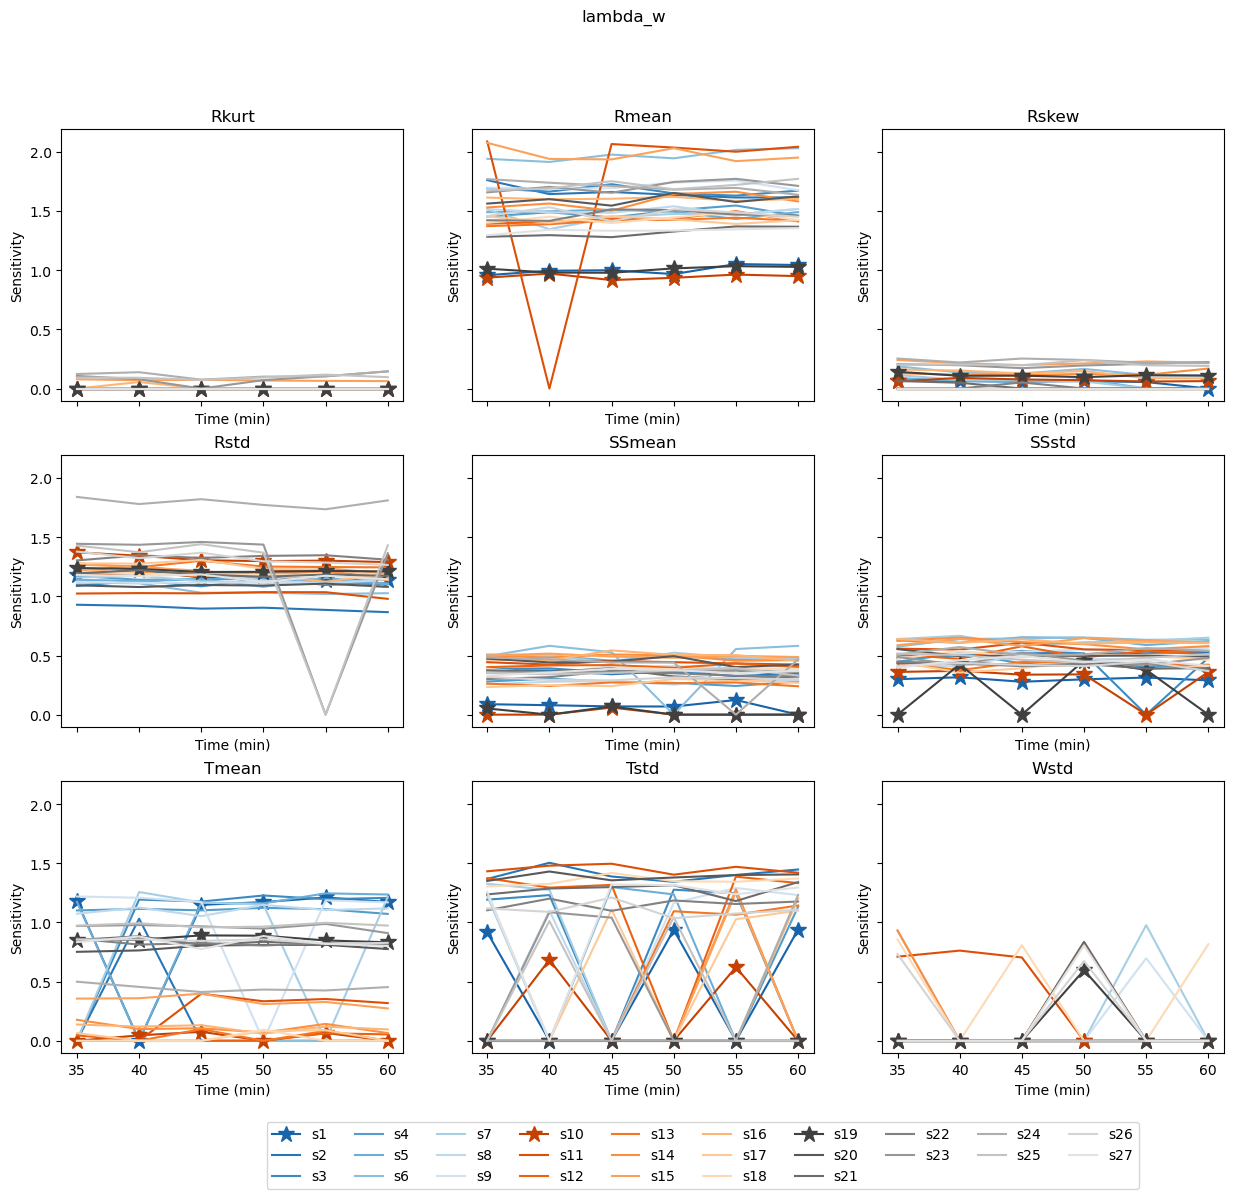

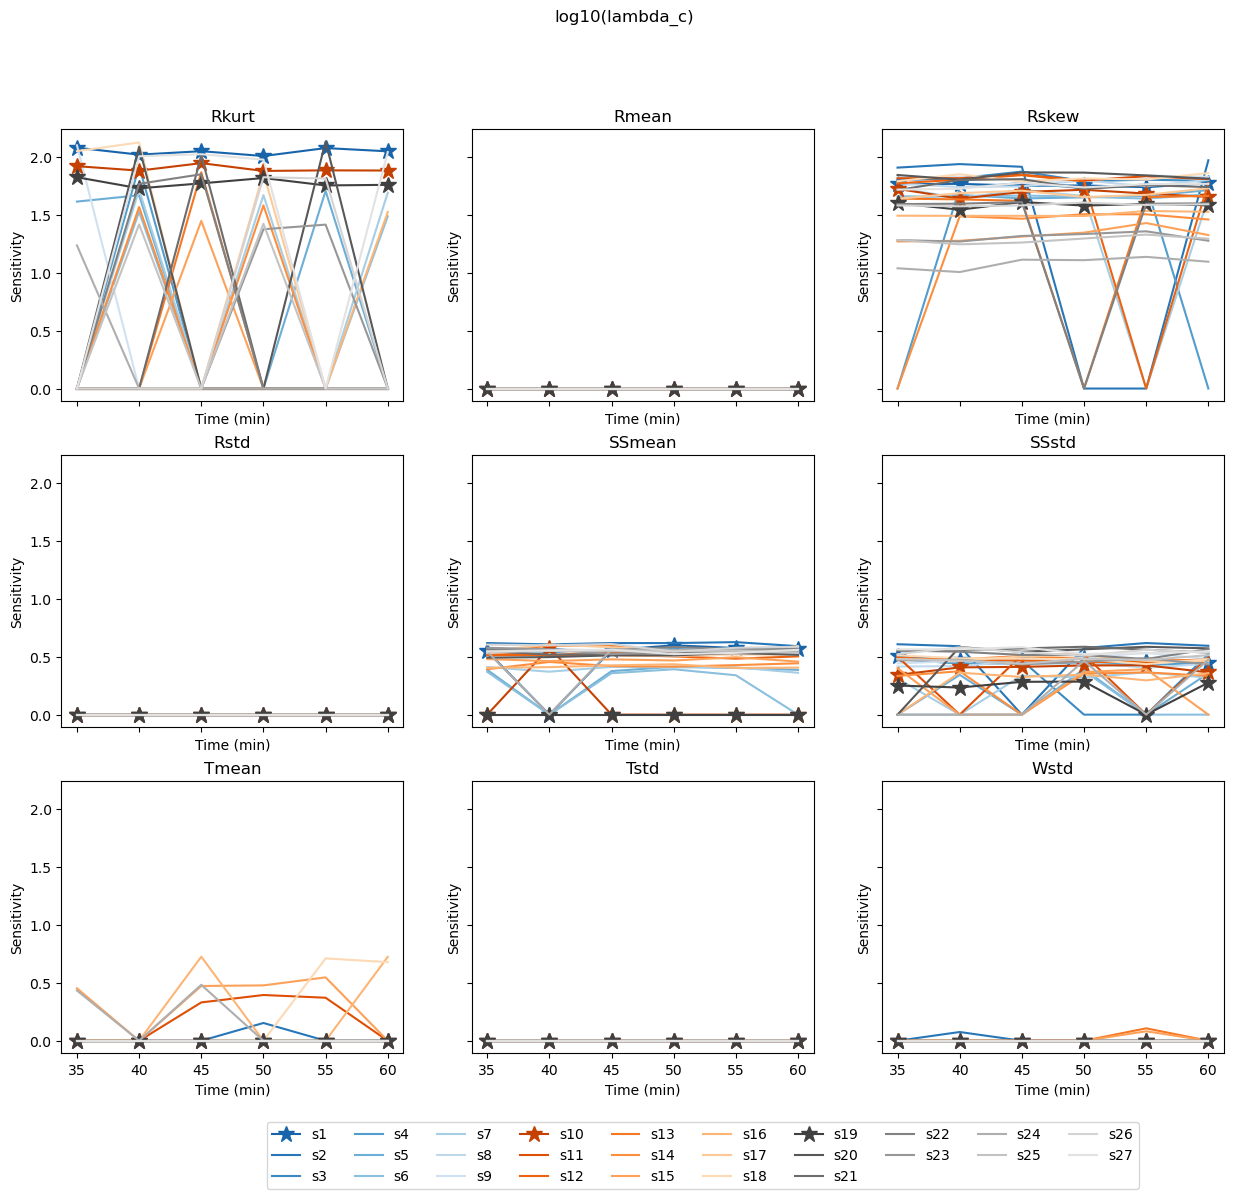

In [55]:
# Plot -- sensitivity filtered by conditional mask
for k,yvarn in enumerate(y_vars):
    fig, axes = plt.subplots(3, 3, figsize=(15,12), sharex=True, sharey=True)
    axes = axes.flatten()
    for i,varn in enumerate(varn_set):
        ax = axes[i]
        for j,loc in enumerate(loc_set):
            df = df_sen[(df_sen['varn']==varn) & (df_sen['loc']==loc)].copy()
            t, d = df['time'].values, df[yvarn].values
            m = df[yvarn+'_condmask']
            d[~m] = 0 
            if loc in [1, 10, 19]:
                ax.plot(t, d, '-*', label=f"s{loc}", markersize=12, color=colors[j])
            else:
                ax.plot(t, d, label=f"s{loc}", color=colors[j])
        ax.set(title=varn, xlabel='Time (min)', ylabel='Sensitivity')
    ax.legend(loc=[-1.8, -0.5], ncols=10)
    plt.suptitle(yvarn)


# Load the mapping results

In [13]:
f_kim_save1 = Path("./results/map_many2many")
f_kim_save2 = Path("./results/map_many2one")
f_kim_save3 = Path("./results/map_many2one_cond")


In [72]:
kim1.maps[0].model_ens[0]

MLP(
  layers=(
    Linear(
      weight=f32[6,1458],
      bias=f32[6],
      in_features=1458,
      out_features=6,
      use_bias=True
    ),
    Linear(
      weight=f32[2,6],
      bias=f32[2],
      in_features=6,
      out_features=2,
      use_bias=True
    )
  ),
  hidden_activation=<wrapped function sigmoid>,
  final_activation=<wrapped function leaky_relu>
)

In [14]:
# Initialize three diffferent KIMs
kim1 = KIM(data, map_configs={}, map_option='many2many')
kim2 = KIM(data, map_configs={}, mask_option="sensitivity", map_option='many2one')
kim3 = KIM(data, map_configs={}, mask_option="cond_sensitivity", map_option='many2one')

# Load the trained mappings
kim1.load(f_kim_save1)
kim2.load(f_kim_save2)
kim3.load(f_kim_save3)


In [50]:
# print(np.mean([loss[-1] for loss in kim1.maps[0].loss_test_ens]))
# print(np.mean([loss[-1] for loss in kim2.maps[0].loss_test_ens]))
# print(np.mean([loss[-1] for loss in kim3.maps[0].loss_test_ens]))
# kims = [kim1, kim2, kim3]


In [51]:
# Calculate the performance metrics
kims = [kim1, kim2, kim3]
labels = ['kim1', 'kim2', 'kim3']
results = {}
for i,kim in enumerate(kims):
    label = labels[i]
    results[label] = kim1.evaluate_maps_on_givendata()

# y_ens_train_set, y_ens_test_set, y_mw_train_set, y_mw_test_set, y_true_train_set, y_true_test_set, \
#     rmse_train_set, rmse_test_set, mkge_train_set, mkge_test_set = \
#     [], [], [], [], [], [], [], [], [], []
# for kim in kims:
#     y_ens_train, y_ens_test, y_mw_train, y_mw_test, rmse_train, \
#         y_true_train, y_true_test, rmse_test, mkge_train, mkge_test = kim1.evaluate_maps_on_givendata()
#     y_ens_train_set.append(y_ens_train)
#     y_ens_test_set


# Plot the training results

## Prediction versus true

In [63]:
kim3.data.ydata.min(axis=0)

array([ 0.502, -2.   ])

In [70]:
kim3.data.yscaler._mean

AttributeError: 'StandardScaler' object has no attribute '_mean'

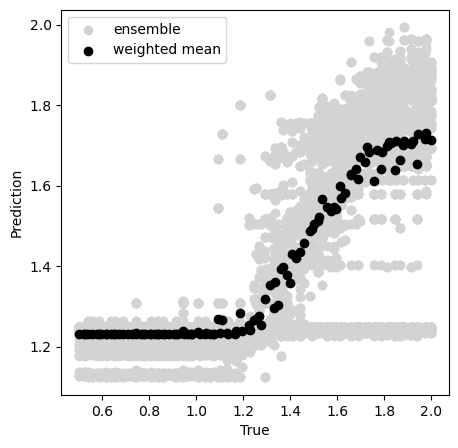

In [64]:
pj, model, train_omean_est = 0, 'kim3', 'test'
r = results[model]
fig, ax = plt.subplots(1,1,figsize=(5,5))
for i in range(100):
    ax.scatter(r['true'][train_or_test][...,pj], r['ens predict'][train_or_test][i,...,pj], 
               color='lightgrey', label='ensemble' if i ==0 else None)
ax.scatter(r['true'][train_or_test][...,pj], r['weighted mean predict'][train_or_test][...,pj], 
           color='black', label='weighted mean')
ax.set(xlabel='True', ylabel='Prediction')
ax.legend()


## Performance boxplots

# Plot the mapping results